In [71]:
from collections import defaultdict
import random

from tqdm.notebook import tqdm

import pandas as pd
from collections import Counter

from scipy import sparse
from scipy.sparse.linalg import svds
import numpy as np

from sklearn.metrics.pairwise import cosine_similarity

from nltk.tokenize import sent_tokenize, word_tokenize, regexp_tokenize

import glob
import re
import matplotlib.pyplot as plt

In [134]:
books = glob.glob('english_books/*')
print(books)

['english_books\\A Christmas Carol in Prose; Being a Ghost Story of Christmas by Charles Dickens.txt', 'english_books\\A Modest Proposal by Jonathan Swift.txt', 'english_books\\A Tale of Two Cities by Charles Dickens.txt', 'english_books\\Adventures of Huckleberry Finn by Mark Twain.txt', 'english_books\\Anna Karenina by graf Leo Tolstoy.txt', 'english_books\\Anne of Green Gables by L. M.  Montgomery.txt', 'english_books\\Anthem by Ayn Rand.txt', 'english_books\\Crime and Punishment by Fyodor Dostoyevsky.txt', 'english_books\\Don Quixote by Miguel de Cervantes Saavedra.txt', 'english_books\\Dracula by Bram Stoker.txt', 'english_books\\Dubliners by James Joyce.txt', 'english_books\\Emma by Jane Austen.txt', 'english_books\\Frankenstein; Or, The Modern Prometheus by Mary Wollstonecraft Shelley.txt', 'english_books\\Great Expectations by Charles Dickens.txt', 'english_books\\Heart of Darkness by Joseph Conrad.txt', 'english_books\\Jane Eyre_ An Autobiography by Charlotte Brontë.txt', 'eng

In [145]:
all_book = ""
for b in books:
    book = b[14:]
    if book != "The_Scarlet_Letter_by_Nathaniel_Hawthorne.txt":
    #if book == "The_Adventures_of_Sherlock_Holmes_by_Arthur_Conan_Doyle.txt" or book == "The_Scarlet_Letter_by_Nathaniel_Hawthorne.txt":    
        print(book)
        with open('english_books\\'+book,encoding="utf8") as fi:
            book_r = fi.read()
        start_b = re.search(r"\*\*\*[\w|\s]+[\;|\w]+[\w|\s]+\*\*\*",book_r)
        #print(start_b)
        end = start_b.end()
        #print(book_r)
        try_book = book_r[end:]
        end_b = re.search(r"\*\*\*[\w|\s]+[\;|\w]+[\w|\s]+\*\*\*",try_book)
        cut_off = end_b.start()
        complete_b = try_book[:cut_off]
        all_book = all_book + complete_b

A Christmas Carol in Prose; Being a Ghost Story of Christmas by Charles Dickens.txt
A Modest Proposal by Jonathan Swift.txt
A Tale of Two Cities by Charles Dickens.txt
Adventures of Huckleberry Finn by Mark Twain.txt
Anna Karenina by graf Leo Tolstoy.txt
Anne of Green Gables by L. M.  Montgomery.txt
Anthem by Ayn Rand.txt
Crime and Punishment by Fyodor Dostoyevsky.txt
Don Quixote by Miguel de Cervantes Saavedra.txt
Dracula by Bram Stoker.txt
Dubliners by James Joyce.txt
Emma by Jane Austen.txt
Frankenstein; Or, The Modern Prometheus by Mary Wollstonecraft Shelley.txt
Great Expectations by Charles Dickens.txt
Heart of Darkness by Joseph Conrad.txt
Jane Eyre_ An Autobiography by Charlotte Brontë.txt
Japanese Girls and Women by Alice Mabel Bacon.txt
Les Misérables by Victor Hugo.txt
Leviathan by Thomas Hobbes.txt
Little Women by Louisa May Alcott.txt
Metamorphosis by Franz Kafka.txt
Moby Dick; Or, The Whale by Herman Melville.txt
Narrative of the Life of Frederick Douglass, an American Sl

In [154]:
book_r_words = [x.lower() for x in regexp_tokenize(all_book, '\w+')]
book_r_counter = Counter(book_r_words).most_common(100)

In [155]:
print(book_r_counter)

[('the', 394701), ('and', 251180), ('of', 200453), ('to', 193529), ('a', 145177), ('i', 118866), ('in', 115758), ('he', 102809), ('that', 97177), ('it', 87001), ('was', 80659), ('his', 76135), ('you', 69208), ('with', 59688), ('for', 56137), ('is', 54939), ('as', 54727), ('not', 51171), ('had', 50623), ('her', 48714), ('but', 47999), ('at', 44906), ('s', 42300), ('him', 41997), ('on', 41988), ('be', 41307), ('she', 39169), ('have', 35562), ('all', 34712), ('my', 34314), ('by', 32147), ('me', 32146), ('they', 31310), ('said', 30215), ('this', 30048), ('which', 29939), ('so', 29148), ('from', 28542), ('one', 25697), ('what', 25056), ('there', 24421), ('or', 24362), ('were', 23358), ('are', 23094), ('no', 22976), ('we', 20987), ('if', 20902), ('when', 20570), ('them', 20510), ('who', 19886), ('would', 18897), ('an', 18771), ('t', 18707), ('their', 18347), ('will', 17869), ('out', 17223), ('up', 17082), ('been', 17061), ('then', 16148), ('do', 15935), ('your', 15477), ('man', 15132), ('now

In [156]:
for item in book_r_counter:
    top_count = item[1]
    break

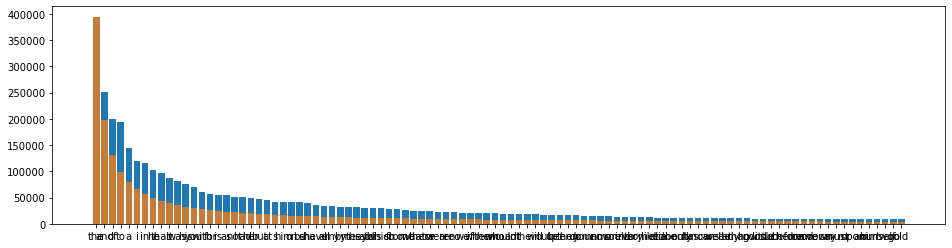

In [157]:
plt.rcParams["figure.figsize"] = [16, 4]
ind = []
fre = []
fretwo = []
run = 1
for item in book_r_counter:
    ind.append(item[0])
    fre.append(item[1])
    fretwo.append(top_count/run)
    run = run + 1

plt.bar(ind, fre, alpha = 1)
plt.bar(ind, fretwo, alpha =  .75)

plt.show()

In [151]:
#words = Counter(book_r_counter.read().split()).most_common(10)
print(words)

NameError: name 'words' is not defined

In [150]:
print(fre)

[394701, 251180, 200453, 193529, 145177, 118866, 115758, 102809, 97177, 87001, 80659, 76135, 69208, 59688, 56137, 54939, 54727, 51171, 50623, 48714, 47999, 44906, 42300, 41997, 41988, 41307, 39169, 35562, 34712, 34314, 32147, 32146, 31310, 30215, 30048, 29939, 29148, 28542, 25697, 25056, 24421, 24362, 23358, 23094, 22976, 20987, 20902, 20570, 20510, 19886]


In [152]:
print(book_r_counter)

[('the', 394701), ('and', 251180), ('of', 200453), ('to', 193529), ('a', 145177), ('i', 118866), ('in', 115758), ('he', 102809), ('that', 97177), ('it', 87001), ('was', 80659), ('his', 76135), ('you', 69208), ('with', 59688), ('for', 56137), ('is', 54939), ('as', 54727), ('not', 51171), ('had', 50623), ('her', 48714), ('but', 47999), ('at', 44906), ('s', 42300), ('him', 41997), ('on', 41988), ('be', 41307), ('she', 39169), ('have', 35562), ('all', 34712), ('my', 34314), ('by', 32147), ('me', 32146), ('they', 31310), ('said', 30215), ('this', 30048), ('which', 29939), ('so', 29148), ('from', 28542), ('one', 25697), ('what', 25056), ('there', 24421), ('or', 24362), ('were', 23358), ('are', 23094), ('no', 22976), ('we', 20987), ('if', 20902), ('when', 20570), ('them', 20510), ('who', 19886)]


In [153]:
for x in book_r_counter:
    print(x)

('the', 394701)
('and', 251180)
('of', 200453)
('to', 193529)
('a', 145177)
('i', 118866)
('in', 115758)
('he', 102809)
('that', 97177)
('it', 87001)
('was', 80659)
('his', 76135)
('you', 69208)
('with', 59688)
('for', 56137)
('is', 54939)
('as', 54727)
('not', 51171)
('had', 50623)
('her', 48714)
('but', 47999)
('at', 44906)
('s', 42300)
('him', 41997)
('on', 41988)
('be', 41307)
('she', 39169)
('have', 35562)
('all', 34712)
('my', 34314)
('by', 32147)
('me', 32146)
('they', 31310)
('said', 30215)
('this', 30048)
('which', 29939)
('so', 29148)
('from', 28542)
('one', 25697)
('what', 25056)
('there', 24421)
('or', 24362)
('were', 23358)
('are', 23094)
('no', 22976)
('we', 20987)
('if', 20902)
('when', 20570)
('them', 20510)
('who', 19886)


In [ ]:
book_r_counter['the']